# Analyzing only threads with Ad-Hominem
(for full thread analysis, see `full-cmv-data-analysis`)

* Extract threads that contain some ad-hominem arguments; but only those with a distinct label (not for example 'low effort comments')

In [1]:
from RedditThread import RedditThread

threads = RedditThread.load_or_unpickle_ad_hominem_threads()
print("Threads with ad-hominem:", len(threads))

Threads with ad-hominem: 3996


In [2]:
all_comments = RedditThread.collect_all_comments(threads)
print('Unique comments total:', len(all_comments), 'comments')
print('Unique comments ad-hominem:', len([x for x in all_comments if x.is_ad_hominem()]))
all_comments = None

Unique comments total: 29278 comments
Unique comments ad-hominem: 3866


* How many ad-hominem arguments per thread?

In [3]:
from pandas import DataFrame


def ad_hominem_comments_count_per_thread(t: list) -> list:
    """
    Returns a list with counts of ad-hominem arguments in threads
    :param t: list of RedditThread
    :return: list of integers
    """
    result = []
    for thread in t:
        assert isinstance(thread, RedditThread)
        # count all ad-hominem
        result.append(sum([1 for comment in thread.comments if comment.is_ad_hominem()]))
    return result


ad_hominem_comments_count = ad_hominem_comments_count_per_thread(threads)
df = DataFrame(data=ad_hominem_comments_count)
df.describe()

,0
count,3996.000000
mean,1.197698
std,0.537416
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,6.000000


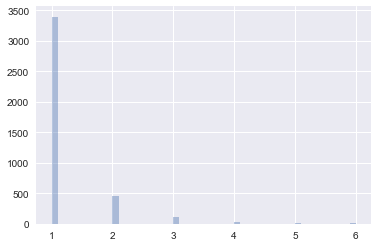

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

import warnings
warnings.filterwarnings('ignore')

seaborn.set(color_codes=True)
seaborn.distplot(ad_hominem_comments_count, kde=False)
plt.show()

In [5]:
ad_hominem_comments_count_dist = dict()
for x in ad_hominem_comments_count:
    ad_hominem_comments_count_dist[x] = ad_hominem_comments_count_dist.get(x, 0) + 1
print(ad_hominem_comments_count_dist)

{1: 3396, 2: 460, 3: 105, 4: 25, 5: 5, 6: 5}


* Are ad-hominem the last arguments?

In [6]:
last_comment_ad_hominem = {True: 0, False: 0}

for thread in threads:
    assert isinstance(thread, RedditThread)
    _ = thread.comments[-1].is_ad_hominem()
    last_comment_ad_hominem[_] = last_comment_ad_hominem.get(_) + 1
    
assert sum(last_comment_ad_hominem.values()) == len(threads)
print(last_comment_ad_hominem)

{False: 2055, True: 1941}


* In how many cases is a reaction to ad-hominem also ad-hominem?

In [7]:
reaction_to_ad_hominem_is_ad_hominem = {True: 0, False: 0}
for thread in threads:
    for i, _ in enumerate(thread.comments):
        if i < (len(thread.comments) - 1):
            j = i + 1
            current_comment = thread.comments[i]
            next_comment = thread.comments[j]
            
            if current_comment.is_ad_hominem():
                _ = next_comment.is_ad_hominem()
                reaction_to_ad_hominem_is_ad_hominem[_] = reaction_to_ad_hominem_is_ad_hominem.get(_) + 1

print(reaction_to_ad_hominem_is_ad_hominem)

{False: 2405, True: 440}


* Before calling names: What is the average number of comments before ad-hominem first appear?

In [8]:
numbers_of_good_comments_before_ad_hominem = []
for thread in threads:
    assert isinstance(thread, RedditThread)
    _ = thread.get_positions_of_ad_hominem_comments()[0]
    numbers_of_good_comments_before_ad_hominem.append(_)
    
df = DataFrame(numbers_of_good_comments_before_ad_hominem)
df.describe()

,0
count,3996.000000
mean,6.468969
std,5.775377
min,1.000000
25%,3.000000
50%,5.000000
75%,9.000000
max,115.000000


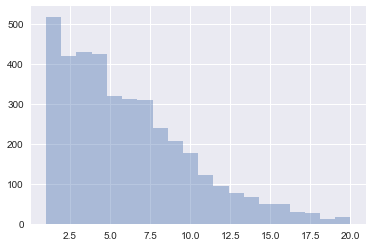

In [9]:
max_limit = 20
_ = [x for x in numbers_of_good_comments_before_ad_hominem if x <= max_limit]

seaborn.distplot(_, kde=None, bins=max_limit)
plt.show()

* The same but now proportional to the thread length

In [10]:
numbers_of_good_comments_before_ad_hominem_relative = []
for thread in threads:
    assert isinstance(thread, RedditThread)
    _ = thread.get_positions_of_ad_hominem_comments()[0] + 1
    _ = _ / len(thread.comments)
    numbers_of_good_comments_before_ad_hominem_relative.append(_)
    
df = DataFrame(numbers_of_good_comments_before_ad_hominem_relative)
df.describe()

,0
count,3996.000000
mean,0.804584
std,0.221370
min,0.090909
25%,0.666667
50%,0.875000
75%,1.000000
max,1.000000


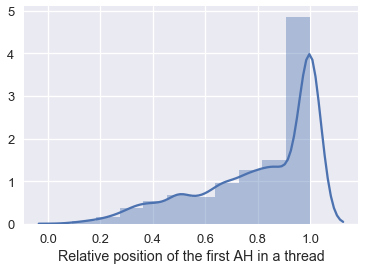

In [11]:
seaborn.set_context("talk")
seaborn.distplot(numbers_of_good_comments_before_ad_hominem_relative, axlabel='Relative position of the first AH in a thread', bins=10)
# plt.legend()
plt.savefig('/tmp/out.pdf')
plt.show()

* Is there any correlation of the thread length and the position of the first ad-hominem?

Pearson correlation, p-value: (-0.2266844683050094, 9.811452329887584e-48)


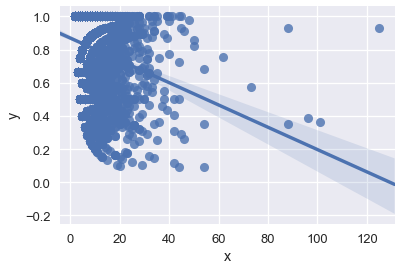

In [12]:
import scipy.stats.stats

thread_lengths = [len(thread.comments) for thread in threads]

print('Pearson correlation, p-value:', scipy.stats.stats.pearsonr(thread_lengths, numbers_of_good_comments_before_ad_hominem_relative))

_, ax = plt.subplots()
# ax.set(xscale="log")
seaborn.regplot(x='x', y='y',
                data=DataFrame(data={'x': thread_lengths, 'y': numbers_of_good_comments_before_ad_hominem_relative}),
                fit_reg=True, ax=ax)
plt.show()


So the correlation is quite weak...

## Ad-hominem threads and submissions
* Concentration of ad-hominem threads to the same topic (group by the first comment = OP)

In [13]:
# map: op.name, list of threads
threads_grouped_by_op = RedditThread.group_threads_by_original_post(threads)
    
print('Submissions with ad-hominem threads:', len(threads_grouped_by_op))

Submissions with ad-hominem threads: 2085


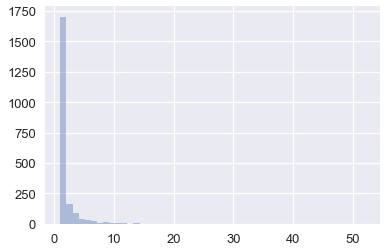

In [14]:
threads_grouped_by_op_counts = [len(_) for _ in threads_grouped_by_op.values()]

seaborn.distplot(threads_grouped_by_op_counts, kde=False)
plt.show()

In [15]:
DataFrame(threads_grouped_by_op_counts).describe()

,0
count,2085.000000
mean,1.916547
std,2.352713
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,52.000000


Most submissions thus have only one or two ad-hominem (75%) but there's also one submission having 53 threads with ad-hominem!
* What are these extremes?

In [16]:
# show OP with more than 10 ad-hominem threads
from AnnotatedRedditComment import AnnotatedRedditComment
import pandas

names = []
counts = []

# names = ['adsf', 'wrwer']
# counts = [1, 3]
for thread_list in threads_grouped_by_op.values():
    current_length = len(thread_list)
    
    if current_length >= 10:
        t = thread_list[0]
        assert isinstance(t, RedditThread)
        c = t.comments[0]
        assert isinstance(c, AnnotatedRedditComment)
        # add title and counts
        names.append(c.title)
        counts.append(current_length)

pandas.options.display.max_colwidth = 200
df = DataFrame({'OP': names, 'Ad-hominem threads': counts}).sort_values('Ad-hominem threads', ascending=False)
df

,Ad-hominem threads,OP
21,52,"CMV: you cannot claim to respect all religions if you are against Satanism, and by extension it is wrong to censor Satanic imagery in media unless you do the same for all religions."
18,37,CMV: Transgender people should disclose they are transgender before engaging in physically intimate acts with another person.
20,34,CMV: It is a lot harder being a guy than it is being a woman
13,25,CMV: Banning the hate groups from having websites or places to express their opinion is a bad thing
16,20,CMV: post-op transgender people should always inform new partners before engaging in sexual activities
3,18,"CMV: There is a very serious problem with ""black culture"" in America that nobody is willing to call out or speak honestly about, and this needs to change ASAP"
19,17,CMV: Supporters of President Trump should not be mocked or ignored if Democrats want to win elections
2,15,CMV: There is nothing morally wrong with building a wall to keep out potential illegal immigrants
8,14,CMV: Reddit was wrong to ban /r/fatpeoplehate but not /r/shitredditsays.
17,14,"CMV: Neo-nazis, white supremacists, confederate sympathizers are not on par with BLM and antifa"


So here we go:
1. Religion
2. Sexuality and gender (trans-sexuality, homosexuality)
3. US-politics (Trump)
4. Racism in the U.S.
5. Veganism

So the 'crazy' topics and the normal topics have same amount of delta comments (0.7-0.8%)

## Ad-hominem comments and authors

* How many normal comments commit the ad-hominem author before ending up with ad-hominem?

In [17]:
comments_before_ad_hominem_by_its_author = []

for thread in threads:
    assert isinstance(thread, RedditThread)
    # get first ad-hominem
    first_ad_hominem_position = thread.get_positions_of_ad_hominem_comments()[0]
    # get its author
    comment = thread.comments[first_ad_hominem_position]
    assert isinstance(comment, AnnotatedRedditComment)
    comment.author_name
    
    counter = 0
    
    for i in range(first_ad_hominem_position - 1):
        c = thread.comments[i]
        assert isinstance(c, AnnotatedRedditComment)
        
        if c.author_name == comment.author_name:
            counter += 1
    
    comments_before_ad_hominem_by_its_author.append(counter)

print(set(comments_before_ad_hominem_by_its_author))
DataFrame(comments_before_ad_hominem_by_its_author).describe()

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 40, 57}


,0
count,3996.000000
mean,1.465716
std,2.563355
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,57.000000


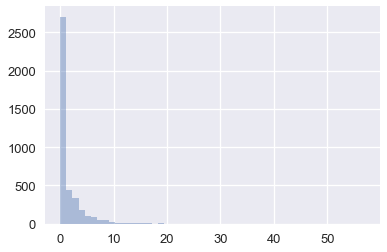

In [18]:
seaborn.distplot(comments_before_ad_hominem_by_its_author, kde=False)
plt.show()

About 66% ad-hominem posters post without previous interaction, 11% write at least one post in the thread, 6% two posts, some outliers also include over 10 turns (with maximum 57 turns)

* How many other people participate before calling names (excluding OP and ad-hominem poster)?

All threads: 3162


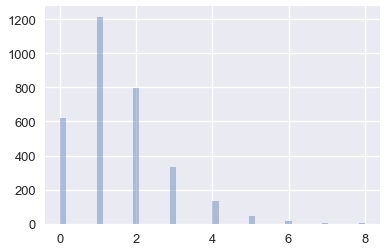

In [19]:
people_before_calling_names = []
op_is_ad_hominem = {True: 0, False: 0}

threads_with_all_author_names = RedditThread.filter_threads_with_all_authors(threads)

for thread in threads_with_all_author_names:
    # get comments between OP and first ad-hominem
    first_ad_hominem_position = thread.get_positions_of_ad_hominem_comments()[0]
    sub_comments = thread.comments[1:first_ad_hominem_position]
    op = thread.comments[0]
    ad_hominem_comment = thread.comments[first_ad_hominem_position]
    
    # print('OP author', op.author_name)
    # print('ad-hominem author', ad_hominem_comment.author_name)
    
    # update counts
    same = op.author_name == ad_hominem_comment.author_name
    op_is_ad_hominem[same] = op_is_ad_hominem[same] + 1
    
    # extract all authors except OP author
    authors = set([c.author_name for c in sub_comments if c.author_name not in [op.author_name, ad_hominem_comment.author_name]])
    
    people_before_calling_names.append(len(authors))

print('All threads:', len(people_before_calling_names))
seaborn.distplot(people_before_calling_names, kde=False)
plt.show()

This is interesting: only about 20% is an interplay between OP and someone else (the zero for "other participants")
* How does the number of participants correlates with the thread length?

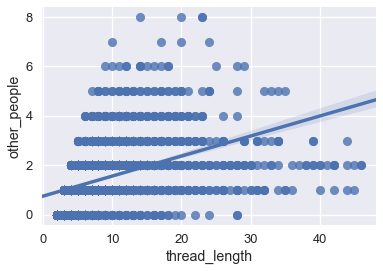

In [20]:
threads_with_all_author_names_lengths = [len(t.comments) for t in threads_with_all_author_names]

# filter outlier (more than 50)
threads_with_all_author_names_lengths_no_outliers = [len(t.comments) for i, t in
                                                     enumerate(threads_with_all_author_names) if len(t.comments) < 50]
people_before_calling_names_no_outliers = [people_before_calling_names[i] for i, t in
                                             enumerate(threads_with_all_author_names) if len(t.comments) < 50]

seaborn.regplot(x='thread_length', y='other_people',
                data=DataFrame(data={'thread_length': threads_with_all_author_names_lengths_no_outliers,
                                     'other_people': people_before_calling_names_no_outliers}),
                fit_reg=True)
plt.show()


So except for outliers (extra long threads), there seem to be usually more people involved in longer threads.


* Are OP also involved in committing the first ad-hominem?

In [21]:
print(op_is_ad_hominem)

{False: 2802, True: 360}


So in 12% the OP himself commit ad-hominem

## Authors comitting ad-hominem

In [22]:
normal_authors = dict()
ad_hominem_authors = dict()

# we must use only threads with know authors: threads_with_all_author_names
for submission in RedditThread.group_threads_by_original_post(threads_with_all_author_names).values():
    assert isinstance(submission, list)
    comments = RedditThread.collect_all_comments(submission)
    
    for comment in comments:
        assert isinstance(comment, AnnotatedRedditComment)
        if comment.is_ad_hominem():
            ad_hominem_authors[comment.author_name] = ad_hominem_authors.get(comment.author_name, 0) + 1
        else:
            normal_authors[comment.author_name] = normal_authors.get(comment.author_name, 0) + 1

print('All normal authors in ad-hominem threads:', len(normal_authors))
print('All authors who committed ad-hominem:', len(ad_hominem_authors))

All normal authors in ad-hominem threads: 4853
All authors who committed ad-hominem: 2180


* Do the distributions (number of comments) differ between ad-hominem authors and normal authors in ad-hominem threads?

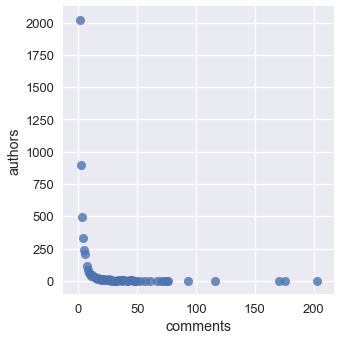

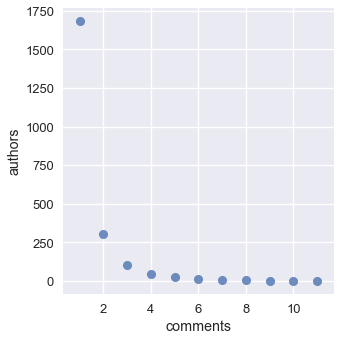

In [23]:
from collections import Counter

labels, values = zip(*Counter(list(normal_authors.values())).items())
df_normal = DataFrame(data={'comments': labels, 'authors': values})
labels, values = zip(*Counter(list(ad_hominem_authors.values())).items())
df_ad_hominem = DataFrame(data={'comments': labels, 'authors': values})

# _, ax = plt.subplots()
# ax.set(yscale="log")
seaborn.lmplot(x='comments', y='authors', data=df_normal, fit_reg=False)
seaborn.lmplot(x='comments', y='authors', data=df_ad_hominem, fit_reg=False)
plt.show()


* The trend is similar, however maximum ad-hominem posts for one person is 13 -- much fewer than for normal comments

Most authors commit ad-hominem once (~1800), ~300 authors twice, only 50 authors four times.

* Are ad-hominem users spread over CMV or are they concentrated around one topic?
	* group submissions
	* all authors
	* number of submissions in which each author commited ad-hominem (only for those who did)

2180


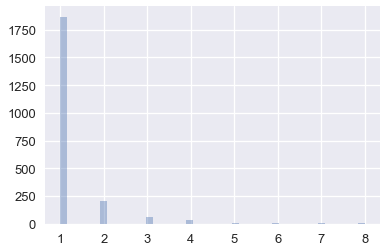

In [24]:
# {author_name, (OP1, OP2, OP3)} - submissions where the author committed ad-hominem
ad_hominem_author_submission_list_dict = dict()
# init empty sets
for author in ad_hominem_authors.keys():
    ad_hominem_author_submission_list_dict[author] = set()

# group submissions
for op, submission_threads in RedditThread.group_threads_by_original_post(threads_with_all_author_names).items():
    for comment in RedditThread.collect_all_comments(submission_threads):
        assert isinstance(comment, AnnotatedRedditComment)
        if comment.is_ad_hominem():
            # add this submission to the list for this author
            ad_hominem_author_submission_list_dict[comment.author_name].add(op)
            
ad_hominem_author_spreads = [len(submissions) for submissions in ad_hominem_author_submission_list_dict.values()]
print(len(ad_hominem_author_spreads))
seaborn.distplot(ad_hominem_author_spreads, kde=False)
plt.show()

They really concetrate around one submission (in ~80%). In 10% they commit ad-hominem in other submissions, too. Very rarely in more submissions.

* Do ad-hominem authors with larger spread write also more ad-hominem comments in general?

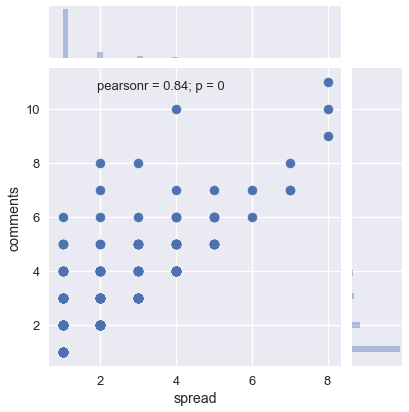

In [25]:
spread = []
comment_count = []

for author in ad_hominem_author_submission_list_dict:
    submissions = ad_hominem_author_submission_list_dict[author]
    comments_total = ad_hominem_authors[author]
    
    spread.append(len(submissions))
    comment_count.append(comments_total)
    
seaborn.jointplot(x='spread', y='comments', data=DataFrame({'spread': spread, 'comments': comment_count}))
plt.show()

There are not many "spammers", i.e., ad-hominem author commits ad-hominem in 6 submissions but writes only max 7 ad-hominem comments in total. Values for lower spread corresponds to the centrality around fewer submission (topics).

* Are ad-hominem authors also writing "normal" comments in CMV?

In [26]:
import os

# we know all authors who committed ad-hominem
len(ad_hominem_authors.keys())

main_dir = '/home/user-ukp/data2/cmv-full-2017-09-22/'
files = [f for f in os.listdir(main_dir) if os.path.isfile(os.path.join(main_dir, f))]

ad_hominem_author_counts_normal = dict()
ad_hominem_author_counts_ad_hominem = dict()
for a in ad_hominem_authors:
    ad_hominem_author_counts_normal[a] = 0
    ad_hominem_author_counts_ad_hominem[a] = 0

for f in files:
    comments = RedditThread.load_comments_from_file(os.path.join(main_dir, f))
    clean_threads = RedditThread.discard_corrupted_threads(RedditThread.reconstruct_threads_from_submission(comments))

    # remove outliers (threads longer than 200 comments)
    clean_threads = [thread for thread in clean_threads if 200 >= len(thread.comments) > 0]

    for comment in RedditThread.collect_all_comments(clean_threads):
        assert isinstance(comment, AnnotatedRedditComment)

        if comment.author_name in ad_hominem_authors:
            if comment.is_ad_hominem():
                ad_hominem_author_counts_ad_hominem[comment.author_name] = ad_hominem_author_counts_ad_hominem.get(
                    comment.author_name) + 1
            else:
                ad_hominem_author_counts_normal[comment.author_name] = ad_hominem_author_counts_normal.get(
                    comment.author_name) + 1

print(len(ad_hominem_author_counts_normal))
print(len(ad_hominem_author_counts_ad_hominem))

2180
2180


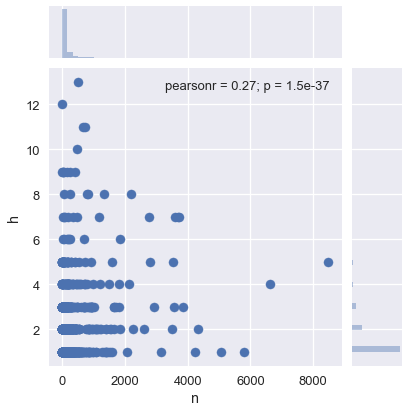

In [27]:
import collections
# show correlation between number of ad-hominem and number of good ones

n = list(collections.OrderedDict(sorted(ad_hominem_author_counts_normal.items())).values())
h = list(collections.OrderedDict(sorted(ad_hominem_author_counts_ad_hominem.items())).values())

seaborn.jointplot(x='n', y='h', data=DataFrame({'n': n, 'h': h}))
plt.show()